In [21]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt

In [22]:
X_train = pd.read_csv('X_train.csv').values
X_test = pd.read_csv('X_test.csv').values
y_train = pd.read_csv('y_train.csv').values
y_test = pd.read_csv('y_test.csv').values

# unpack tensors
X_train = X_train.reshape(80000, 100, 4)
X_test = X_test.reshape(20000, 100, 4)

X_validation = X_train[60000:]
y_validation = y_train[60000:]
X_train = X_train[:60000]
y_train = y_train[:60000]

In [23]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class LSTMClassifier(nn.Module):
    def __init__(self, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = 4,
            hidden_size = hidden_size,
            batch_first = True,
            num_layers = num_layers,
            dropout = dropout
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return torch.sigmoid(self.fc(last)).squeeze(-1)

class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [24]:
from tqdm import tqdm

def train(model, X_train, y_train, n_epochs, learning_rate, optimizer):
    criterion = nn.BCELoss()
    if optimizer == 'ADAM':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    elif optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    training_set = SequenceDataset(X_train, y_train)
    train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=0)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        for X_batch, y_batch in tqdm(train_loader):
            X_batch = X_batch.to('cpu')
            y_batch = y_batch.to('cpu')

            optimizer.zero_grad()

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)

        avg_loss = total_loss / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{n_epochs}, loss = {avg_loss:.4f}")

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

def evaluate(model, X_train, y_train, X_test, y_test):
    model.eval()

    X_test_t = torch.tensor(X_test, dtype=torch.float32).to('cpu')
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to('cpu')
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1).cpu().numpy()
    y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1).cpu().numpy()

    with torch.no_grad():
        train_probs = model(X_train_t).squeeze().cpu().numpy()
        test_probs = model(X_test_t).squeeze().cpu().numpy()
    
    y_train_pred = train_probs > 0.5
    y_pred = test_probs > 0.5

    train_acc = accuracy_score(y_train_t, y_train_pred)
    test_acc = accuracy_score(y_test_t, y_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test_t, test_probs)
    auc = roc_auc_score(y_test_t, test_probs)

    print(f"Train Accuracy: {train_acc:.2%}")
    print(f"Test Accuracy: {test_acc:.2%}")
    print(f"ROC AUC: {auc:.4f}")

    # Plot
    plt.figure(figsize=(6,6))

    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], "k--", label='Random Guessing')

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# Untuned Performance

In [26]:
first_model = LSTMClassifier(
    hidden_size = 16,
    num_layers  = 1,
    dropout     = 0.0
)

train(first_model, X_train, y_train,
    n_epochs = 10,
    learning_rate = 1e-3,
    optimizer = 'ADAM'
    )

  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 1875/1875 [00:06<00:00, 294.23it/s]


Epoch 1/10, loss = 0.6738


100%|██████████| 1875/1875 [00:06<00:00, 300.78it/s]


Epoch 2/10, loss = 0.6725


100%|██████████| 1875/1875 [00:07<00:00, 253.08it/s]


Epoch 3/10, loss = 0.6723


100%|██████████| 1875/1875 [00:10<00:00, 172.44it/s]


Epoch 4/10, loss = 0.6723


100%|██████████| 1875/1875 [00:12<00:00, 154.02it/s]


Epoch 5/10, loss = 0.6722


100%|██████████| 1875/1875 [00:12<00:00, 146.38it/s]


Epoch 6/10, loss = 0.6722


100%|██████████| 1875/1875 [00:12<00:00, 147.17it/s]


Epoch 7/10, loss = 0.6721


100%|██████████| 1875/1875 [00:09<00:00, 194.48it/s]


Epoch 8/10, loss = 0.6721


100%|██████████| 1875/1875 [00:06<00:00, 290.96it/s]


Epoch 9/10, loss = 0.6721


100%|██████████| 1875/1875 [00:06<00:00, 275.36it/s]

Epoch 10/10, loss = 0.6720


Train Accuracy: 58.25%
Test Accuracy: 58.42%
ROC AUC: 0.6158


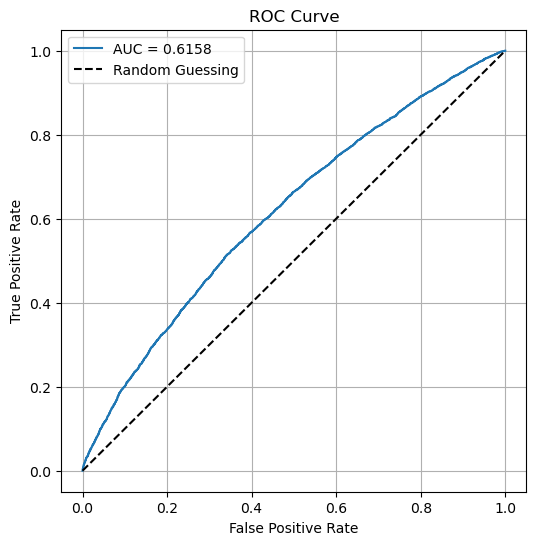

In [27]:
evaluate(first_model, X_train, y_train, X_validation, y_validation)

# Hyperparameter Tuning

## Deep vs Wide

In [28]:
deep_model = LSTMClassifier(
    hidden_size = 8,
    num_layers  = 4,
    dropout = 0.0,
)

wide_model = LSTMClassifier(
    hidden_size = 128,
    num_layers  = 1,
    dropout     = 0.0
)

train(deep_model, X_train, y_train,
    n_epochs = 10,
    learning_rate = 1e-3,
    optimizer = 'ADAM'
    )

train(wide_model, X_train, y_train,
    n_epochs = 10,
    learning_rate = 1e-3,
    optimizer = 'ADAM'
    )


100%|██████████| 1875/1875 [00:18<00:00, 102.48it/s]


Epoch 1/10, loss = 0.6779


100%|██████████| 1875/1875 [00:18<00:00, 101.70it/s]


Epoch 2/10, loss = 0.6735


100%|██████████| 1875/1875 [00:35<00:00, 53.51it/s]


Epoch 3/10, loss = 0.6732


100%|██████████| 1875/1875 [00:31<00:00, 58.77it/s]


Epoch 4/10, loss = 0.6731


100%|██████████| 1875/1875 [00:30<00:00, 62.20it/s]


Epoch 5/10, loss = 0.6727


100%|██████████| 1875/1875 [00:34<00:00, 53.82it/s]


Epoch 6/10, loss = 0.6728


100%|██████████| 1875/1875 [00:34<00:00, 54.57it/s]


Epoch 7/10, loss = 0.6727


100%|██████████| 1875/1875 [00:31<00:00, 60.05it/s] 


Epoch 8/10, loss = 0.6726


100%|██████████| 1875/1875 [00:31<00:00, 60.05it/s] 


Epoch 9/10, loss = 0.6726


100%|██████████| 1875/1875 [00:25<00:00, 74.34it/s] 


Epoch 10/10, loss = 0.6724


100%|██████████| 1875/1875 [00:20<00:00, 91.96it/s]


Epoch 1/10, loss = 0.6734


100%|██████████| 1875/1875 [00:19<00:00, 95.74it/s] 


Epoch 2/10, loss = 0.6725


100%|██████████| 1875/1875 [00:19<00:00, 95.28it/s] 


Epoch 3/10, loss = 0.6725


100%|██████████| 1875/1875 [00:19<00:00, 95.39it/s] 


Epoch 4/10, loss = 0.6724


100%|██████████| 1875/1875 [00:19<00:00, 95.16it/s]


Epoch 5/10, loss = 0.6723


100%|██████████| 1875/1875 [00:19<00:00, 93.76it/s]


Epoch 6/10, loss = 0.6723


100%|██████████| 1875/1875 [00:19<00:00, 95.86it/s] 


Epoch 7/10, loss = 0.6723


100%|██████████| 1875/1875 [00:19<00:00, 95.22it/s]


Epoch 8/10, loss = 0.6723


100%|██████████| 1875/1875 [00:20<00:00, 91.27it/s]


Epoch 9/10, loss = 0.6722


100%|██████████| 1875/1875 [00:22<00:00, 84.28it/s]

Epoch 10/10, loss = 0.6721


Deep LSTM:
Train Accuracy: 58.39%
Test Accuracy: 58.37%
ROC AUC: 0.6149


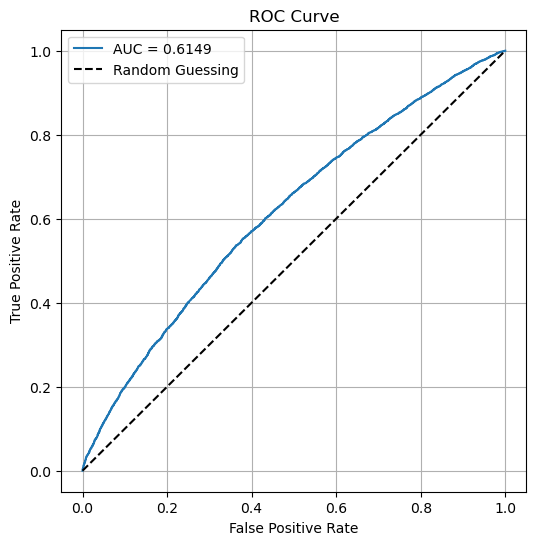

Wide LSTM:
Train Accuracy: 58.28%
Test Accuracy: 58.47%
ROC AUC: 0.6161


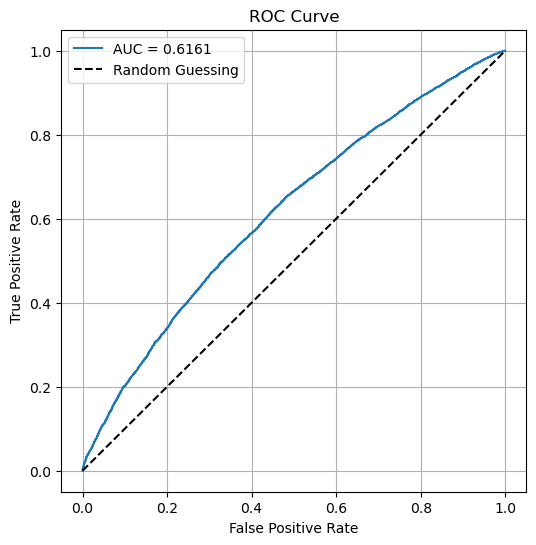

In [29]:
print("Deep LSTM:")
evaluate(deep_model, X_train, y_train, X_validation, y_validation)
print("Wide LSTM:")
evaluate(wide_model, X_train, y_train, X_validation, y_validation)

## Dropout

In [31]:
medium_dropout = LSTMClassifier(
    hidden_size = 8,
    num_layers  = 4,
    dropout     = 0.2
)

high_dropout = LSTMClassifier(
    hidden_size = 8,
    num_layers  = 4,
    dropout     = 0.4
)

train(medium_dropout, X_train, y_train,
    n_epochs = 10,
    learning_rate = 1e-3,
    optimizer = 'ADAM'
    )

train(high_dropout, X_train, y_train,
    n_epochs = 10,
    learning_rate = 1e-3,
    optimizer = 'ADAM'
    )

100%|██████████| 1875/1875 [00:19<00:00, 93.99it/s] 


Epoch 1/10, loss = 0.6796


100%|██████████| 1875/1875 [00:18<00:00, 101.05it/s]


Epoch 2/10, loss = 0.6751


100%|██████████| 1875/1875 [00:18<00:00, 100.54it/s]


Epoch 3/10, loss = 0.6744


100%|██████████| 1875/1875 [00:18<00:00, 99.65it/s] 


Epoch 4/10, loss = 0.6742


100%|██████████| 1875/1875 [00:21<00:00, 87.09it/s]


Epoch 5/10, loss = 0.6741


100%|██████████| 1875/1875 [00:21<00:00, 86.03it/s] 


Epoch 6/10, loss = 0.6738


100%|██████████| 1875/1875 [00:23<00:00, 81.23it/s] 


Epoch 7/10, loss = 0.6737


100%|██████████| 1875/1875 [00:22<00:00, 83.85it/s]


Epoch 8/10, loss = 0.6739


100%|██████████| 1875/1875 [00:19<00:00, 94.62it/s]


Epoch 9/10, loss = 0.6738


100%|██████████| 1875/1875 [00:19<00:00, 94.03it/s]


Epoch 10/10, loss = 0.6732


100%|██████████| 1875/1875 [00:20<00:00, 93.15it/s]


Epoch 1/10, loss = 0.6816


100%|██████████| 1875/1875 [00:21<00:00, 88.99it/s]


Epoch 2/10, loss = 0.6761


100%|██████████| 1875/1875 [00:30<00:00, 60.68it/s]


Epoch 3/10, loss = 0.6755


100%|██████████| 1875/1875 [00:23<00:00, 80.78it/s]


Epoch 4/10, loss = 0.6751


100%|██████████| 1875/1875 [00:20<00:00, 91.61it/s]


Epoch 5/10, loss = 0.6752


100%|██████████| 1875/1875 [00:20<00:00, 91.94it/s]


Epoch 6/10, loss = 0.6749


100%|██████████| 1875/1875 [00:20<00:00, 91.81it/s]


Epoch 7/10, loss = 0.6748


100%|██████████| 1875/1875 [00:20<00:00, 91.05it/s]


Epoch 8/10, loss = 0.6746


100%|██████████| 1875/1875 [00:20<00:00, 91.58it/s]


Epoch 9/10, loss = 0.6744


100%|██████████| 1875/1875 [00:23<00:00, 79.85it/s]

Epoch 10/10, loss = 0.6748


Medium Dropout:
Train Accuracy: 58.19%
Test Accuracy: 58.38%
ROC AUC: 0.6148


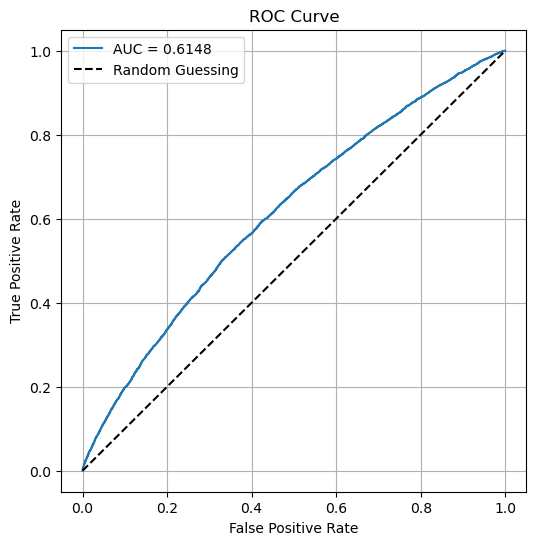

High Dropout:
Train Accuracy: 58.30%
Test Accuracy: 58.48%
ROC AUC: 0.6148


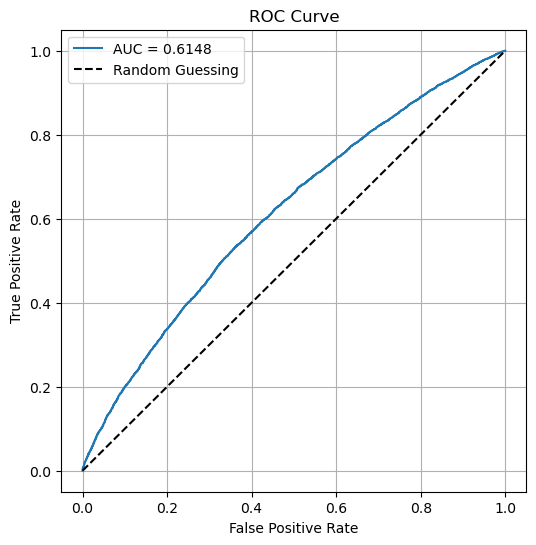

In [32]:
print("Medium Dropout:")
evaluate(medium_dropout, X_train, y_train, X_validation, y_validation)
print("High Dropout:")
evaluate(high_dropout, X_train, y_train, X_validation, y_validation)

## Long vs Short Training 

In [33]:
short_training = LSTMClassifier(
    hidden_size = 128,
    num_layers  = 1,
    dropout     = 0.0
)

long_training = LSTMClassifier(
    hidden_size = 128,
    num_layers  = 1,
    dropout     = 0.0
)

train(short_training, X_train, y_train,
    n_epochs = 5,
    learning_rate = 1e-3,
    optimizer = 'ADAM'
    )

train(long_training, X_train, y_train,
    n_epochs = 25,
    learning_rate = 1e-3,
    optimizer = 'ADAM'
    )

100%|██████████| 1875/1875 [00:45<00:00, 41.63it/s]


Epoch 1/5, loss = 0.6736


100%|██████████| 1875/1875 [00:44<00:00, 41.80it/s]


Epoch 2/5, loss = 0.6727


100%|██████████| 1875/1875 [00:43<00:00, 42.68it/s]


Epoch 3/5, loss = 0.6725


100%|██████████| 1875/1875 [00:41<00:00, 45.02it/s]


Epoch 4/5, loss = 0.6724


100%|██████████| 1875/1875 [00:41<00:00, 45.26it/s]


Epoch 5/5, loss = 0.6724


100%|██████████| 1875/1875 [00:42<00:00, 44.35it/s]


Epoch 1/25, loss = 0.6734


100%|██████████| 1875/1875 [00:42<00:00, 44.39it/s]


Epoch 2/25, loss = 0.6728


100%|██████████| 1875/1875 [00:59<00:00, 31.39it/s]


Epoch 3/25, loss = 0.6724


100%|██████████| 1875/1875 [01:09<00:00, 26.93it/s]


Epoch 4/25, loss = 0.6724


100%|██████████| 1875/1875 [00:43<00:00, 43.15it/s]


Epoch 5/25, loss = 0.6724


100%|██████████| 1875/1875 [00:42<00:00, 44.08it/s]


Epoch 6/25, loss = 0.6724


100%|██████████| 1875/1875 [00:42<00:00, 43.76it/s]


Epoch 7/25, loss = 0.6723


100%|██████████| 1875/1875 [00:42<00:00, 43.69it/s]


Epoch 8/25, loss = 0.6722


100%|██████████| 1875/1875 [01:03<00:00, 29.57it/s]


Epoch 9/25, loss = 0.6723


100%|██████████| 1875/1875 [00:47<00:00, 39.09it/s]


Epoch 10/25, loss = 0.6721


100%|██████████| 1875/1875 [00:42<00:00, 43.66it/s]


Epoch 11/25, loss = 0.6721


100%|██████████| 1875/1875 [00:42<00:00, 43.90it/s]


Epoch 12/25, loss = 0.6720


100%|██████████| 1875/1875 [00:42<00:00, 43.71it/s]


Epoch 13/25, loss = 0.6719


100%|██████████| 1875/1875 [00:48<00:00, 38.42it/s]


Epoch 14/25, loss = 0.6718


100%|██████████| 1875/1875 [00:44<00:00, 41.78it/s]


Epoch 15/25, loss = 0.6717


100%|██████████| 1875/1875 [00:44<00:00, 41.89it/s]


Epoch 16/25, loss = 0.6717


100%|██████████| 1875/1875 [00:42<00:00, 43.97it/s]


Epoch 17/25, loss = 0.6713


100%|██████████| 1875/1875 [00:42<00:00, 43.99it/s]


Epoch 18/25, loss = 0.6711


100%|██████████| 1875/1875 [00:42<00:00, 43.88it/s]


Epoch 19/25, loss = 0.6708


100%|██████████| 1875/1875 [00:43<00:00, 43.59it/s]


Epoch 20/25, loss = 0.6705


100%|██████████| 1875/1875 [00:43<00:00, 42.83it/s]


Epoch 21/25, loss = 0.6700


100%|██████████| 1875/1875 [00:53<00:00, 34.86it/s]


Epoch 22/25, loss = 0.6693


100%|██████████| 1875/1875 [00:52<00:00, 35.42it/s]


Epoch 23/25, loss = 0.6683


100%|██████████| 1875/1875 [00:42<00:00, 43.61it/s]


Epoch 24/25, loss = 0.6675


100%|██████████| 1875/1875 [00:45<00:00, 41.02it/s]

Epoch 25/25, loss = 0.6658


Short Training:
Train Accuracy: 58.39%
Test Accuracy: 58.37%
ROC AUC: 0.6149


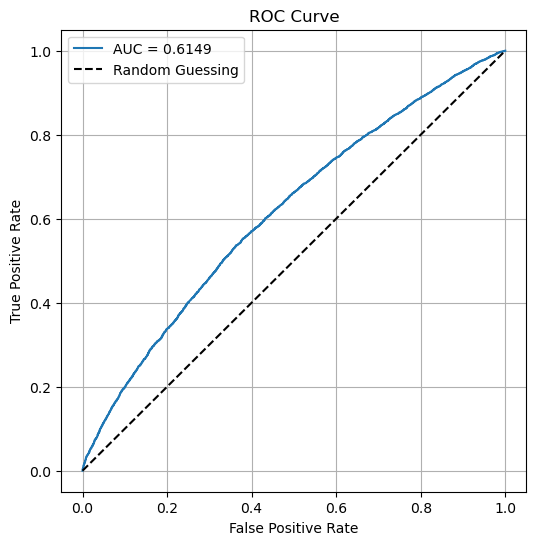

Long Training:
Train Accuracy: 58.28%
Test Accuracy: 58.47%
ROC AUC: 0.6161


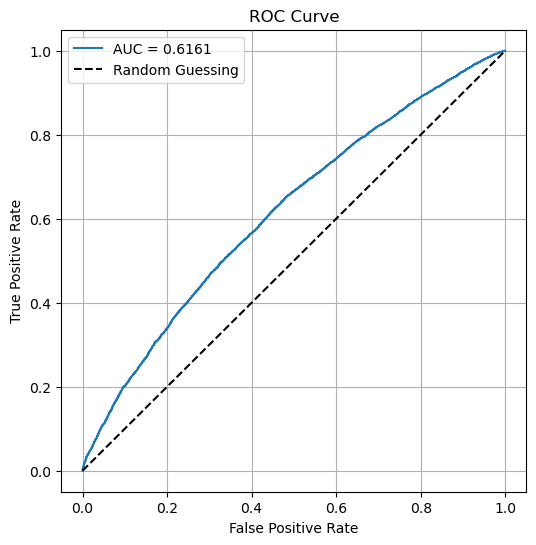

In [34]:
print("Short Training:")
evaluate(deep_model, X_train, y_train, X_validation, y_validation)
print("Long Training:")
evaluate(wide_model, X_train, y_train, X_validation, y_validation)

## SGD vs ADAM

In [35]:
sgd_model = LSTMClassifier(
    hidden_size = 128,
    num_layers = 1,
    dropout = 0.0
)

adam_model = LSTMClassifier(
    hidden_size = 128,
    num_layers = 1,
    dropout = 0.0
)

train(sgd_model, X_train, y_train,
    n_epochs = 10,
    learning_rate = 1e-3,
    optimizer = 'SGD'
    )

train(adam_model, X_train, y_train,
    n_epochs = 10,
    learning_rate = 1e-3,
    optimizer = 'ADAM'
    )

100%|██████████| 1875/1875 [00:47<00:00, 39.77it/s]


Epoch 1/10, loss = 0.6927


100%|██████████| 1875/1875 [00:47<00:00, 39.43it/s]


Epoch 2/10, loss = 0.6904


100%|██████████| 1875/1875 [00:45<00:00, 41.02it/s]


Epoch 3/10, loss = 0.6885


100%|██████████| 1875/1875 [00:45<00:00, 41.40it/s]


Epoch 4/10, loss = 0.6868


100%|██████████| 1875/1875 [00:45<00:00, 41.62it/s]


Epoch 5/10, loss = 0.6852


100%|██████████| 1875/1875 [00:45<00:00, 41.06it/s]


Epoch 6/10, loss = 0.6837


100%|██████████| 1875/1875 [00:47<00:00, 39.23it/s]


Epoch 7/10, loss = 0.6823


100%|██████████| 1875/1875 [00:44<00:00, 41.68it/s]


Epoch 8/10, loss = 0.6810


100%|██████████| 1875/1875 [00:47<00:00, 39.79it/s]


Epoch 9/10, loss = 0.6798


100%|██████████| 1875/1875 [00:45<00:00, 41.61it/s]


Epoch 10/10, loss = 0.6788


100%|██████████| 1875/1875 [00:48<00:00, 38.66it/s]


Epoch 1/10, loss = 0.6733


100%|██████████| 1875/1875 [00:45<00:00, 40.90it/s]


Epoch 2/10, loss = 0.6726


100%|██████████| 1875/1875 [00:45<00:00, 40.89it/s]


Epoch 3/10, loss = 0.6724


100%|██████████| 1875/1875 [00:46<00:00, 39.97it/s]


Epoch 4/10, loss = 0.6724


100%|██████████| 1875/1875 [00:46<00:00, 40.34it/s]


Epoch 5/10, loss = 0.6723


100%|██████████| 1875/1875 [00:46<00:00, 40.23it/s]


Epoch 6/10, loss = 0.6723


100%|██████████| 1875/1875 [00:56<00:00, 33.27it/s]


Epoch 7/10, loss = 0.6722


100%|██████████| 1875/1875 [01:11<00:00, 26.33it/s]


Epoch 8/10, loss = 0.6721


100%|██████████| 1875/1875 [00:58<00:00, 32.10it/s]


Epoch 9/10, loss = 0.6722


100%|██████████| 1875/1875 [00:51<00:00, 36.72it/s]

Epoch 10/10, loss = 0.6722


SGD:
Train Accuracy: 57.63%
Test Accuracy: 57.78%
ROC AUC: 0.6104


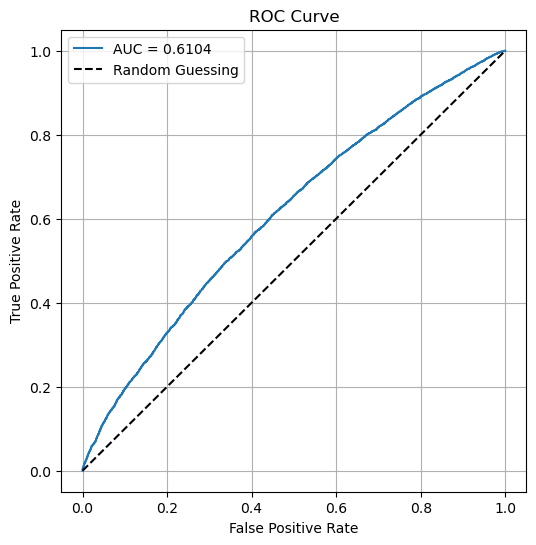

ADAM:
Train Accuracy: 58.27%
Test Accuracy: 58.34%
ROC AUC: 0.6158


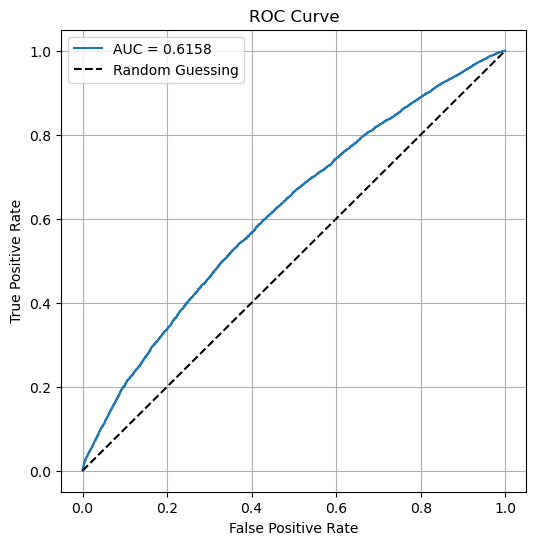

In [36]:
print("SGD:")
evaluate(sgd_model, X_train, y_train, X_validation, y_validation)
print("ADAM:")
evaluate(adam_model, X_train, y_train, X_validation, y_validation)